# Digit recognizer

**Goal**: Create a neural network that can classify hand-written digits into one of ten classes (0-9).

Contents of this notebook:
- [Import libraries](#Import-libraries)
- [Data loading and preprocessing](#Data-loading-and-preprocessing)
- [Create neural network](#Create-neural-network)
- [Data augmentation](#Data-augmentation)

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
%matplotlib inline

# Data loading and preprocessing

First, I'll define some important functions for loading, preprocessing, and displaying data.

In [2]:
def preprocess_img_data(data):
    """ Preprocess image data. Scale pixel values to be in range [0, 1], reshape images from 1D to 2D.
            Input:
                data: pd.DataFrame with pixel values for data, dimensions: (n_samples, 784 (n_pixels))
            Output:
                np array of images, dimensions: (n_samples, 28 (n_pixelsy), 28 (n_pixelsx), 1 (n_channels))
    """
    # Scale pixel values from 0 to 1
    data /= 255
    
    # Convert data from dataframe to numpy array
    data = data.to_numpy()
    
    # Reshape image data to original image dimensions (28 x 28)
    data = data.reshape((-1, 28, 28, 1))
    
    return data

def load_img_data(data_path, y_incl = True):
    """ Load image data, perform preprocessing.
            Input:
                data_path: string, path to csv file containing image data
                y_incl: boolean flag for whether labels are included with data (default: True)
            Output:
                X_data: np array of images, dimensions: (n_samples, 28 (n_pixelsy), 28 (n_pixelsx), 1 (n_channels))
                y_data: np array of image labels (if y_incl is False, returns None), dimensions: (n_samples, 1)
    """
    # Read csv file containing data
    data = pd.read_csv(data_path)
    
    # If labels included, separate image data from labels
    if y_incl:
        # Separate image data from labels
        X_data = data.drop([data.columns[0]], axis=1)
        y_data = data.get(data.columns[0]).to_numpy()
        y_data = y_data.reshape((-1, 1))
    else:
        X_data = data
        y_data = None
        
    # Preprocess image data (scale pixel values, reshape)
    X_data = preprocess_img_data(X_data)
    
    return X_data, y_data

def display_image(img_array, ind):
    """ Display single image.
            Input:
                img_array: np array of images, dimensions: (n_samples, 28 (n_pixelsy), 28 (n_pixelsx), 1 (n_channels))
                ind: int index of image in array
    """
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.squeeze(img_array[ind,:,:,:]))

def display_several_images(img_array, inds, labels=None):
    """ Display list of images. If labels provided, show labels in figure title.
            Input:
                img_array: np array of images, dimensions: (n_samples, 28 (n_pixelsy), 28 (n_pixelsx), 1 (n_channels))
                inds: list of indices of images in array
                labels: np array of image labels, dimensions: (n_samples, 1)
    """
    ncols = 5
    nrows = np.ceil(len(inds)/ncols).astype(int)
    
    fig, ax = plt.subplots(nrows = nrows, ncols = ncols, figsize = (12,2.5*nrows))
    ax = ax.ravel()
    
    for subp,ind in enumerate(inds):
        # Show image
        ax[subp].imshow(np.squeeze(img_array[ind,:,:,:]))
        ax[subp].set_xticks([])
        ax[subp].set_yticks([])
        
        if labels is not None:
            ax[subp].set_title(f'Label {labels[ind]}')

Load data and verify that the shapes of the variables make sense.

In [3]:
# Load training and testing data, preprocess images
X_train, y_train = load_img_data('train.csv')
X_test, _ = load_img_data('test.csv', y_incl = False)

# Print dimensions of data
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (42000, 28, 28, 1)
Shape of y_train: (42000, 1)
Shape of X_test: (28000, 28, 28, 1)


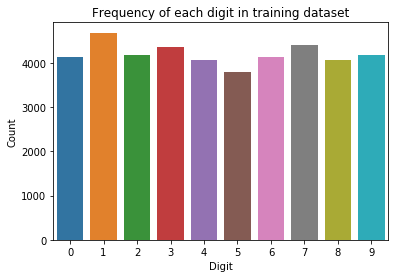

In [4]:
sns.countplot(np.squeeze(y_train))
plt.title('Frequency of each digit in training dataset')
plt.xlabel('Digit')
plt.ylabel('Count')
plt.show()

The training dataset has 42000 images, and the test dataset has 28000 images. Images are relatively evenly split between classes.

Let's look at one image from each class. Images from each class are selected randomly, so the cell below can be run repeatedly to view different samples.

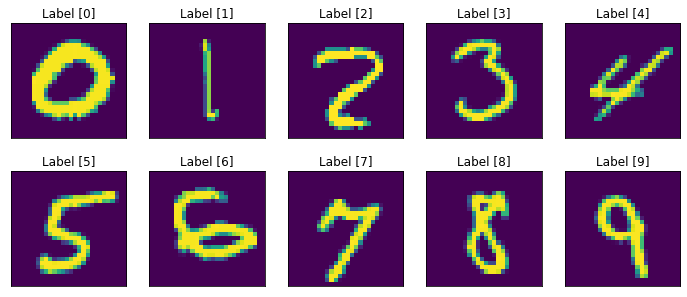

In [5]:
# Store indices of images in list
img_inds = []

for val in range(10):
    # Find list of indices where label = val
    ind = np.squeeze(np.argwhere(y_train.reshape(-1)==val))
    
    # Select one index from ind randomly
    disp_ind = np.random.choice(ind)
    
    # Add index to list to display
    img_inds.append(disp_ind)

# Display images
display_several_images(X_train, img_inds, y_train)

Everything looks as expected, so let's make a model.

# Create neural network

A convolutional neural network (CNN) makes the most sense for creating a computer vision model. Here I'll use Keras to make my model.

But first, two functions to display model results.

In [6]:
def plot_model_results(history):
    # Access accuracy and loss values from model fit
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Create figure
    plt.figure(figsize=(12,4))

    # X variable for plot: epoch number
    x_plot = np.arange(1, len(accuracy)+1)

    # Plot accuracy of training and validation sets
    plt.subplot(1,2,1)
    plt.plot(x_plot, accuracy, 'r', label = 'Training accuracy')
    plt.plot(x_plot, val_accuracy, 'b', label = 'Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss of training and validation sets
    plt.subplot(1,2,2)
    plt.plot(x_plot, loss, 'r', label = 'Training loss')
    plt.plot(x_plot, val_loss, 'b', label = 'Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

def plot_conf_matrix(y, y_predictions):
    conf_matrix = confusion_matrix(y, y_predictions)
    plt.figure()
    sns.heatmap(conf_matrix, annot = True)
    plt.xlabel('Correct class')
    plt.ylabel('Predicted class')
    plt.show()

Create a CNN as a sequential model using Keras.

In [7]:
# Create a sequential model
CNN = models.Sequential()

# First block: include 2 convolutional layers, max pooling layer, and 25% dropout
CNN.add(layers.Conv2D(32, (5, 5), activation = 'relu', input_shape = (28, 28, 1), padding = 'same'))
CNN.add(layers.Conv2D(32, (5, 5), activation = 'relu', input_shape = (28, 28, 1), padding = 'same'))
CNN.add(layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
CNN.add(layers.Dropout(0.25))

# First block: include 2 convolutional layers, max pooling layer, and 25% dropout
CNN.add(layers.Conv2D(32, (3, 3), activation = 'relu', padding = 'same'))
CNN.add(layers.Conv2D(64, (3, 3), activation = 'relu', padding = 'same'))
CNN.add(layers.MaxPooling2D(pool_size = (2,2), strides = (2,2)))
CNN.add(layers.Dropout(0.25))

# Flatten units and send to series of fully connected layers
CNN.add(layers.Flatten())
CNN.add(layers.Dense(120, activation = 'relu'))
CNN.add(layers.Dropout(0.25))
CNN.add(layers.Dense(120, activation = 'relu'))
CNN.add(layers.Dropout(0.25))
CNN.add(layers.Dense(60, activation = 'relu'))

# Final layer uses softmax activation function to facilitate classification into one of 10 classes
CNN.add(layers.Dense(10, activation = 'softmax'))

# Compile model with Adam optimizer
CNN.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

# Store initialized weights to allow other implementations of model to start from same point
weights = CNN.get_weights()

Let's take a look at this model:

In [8]:
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0

Train the model.

In [9]:
# Split training data into train and dev sets
X_train1, X_dev1, y_train1, y_dev1 = train_test_split(X_train, y_train, test_size = 0.1)

history = CNN.fit(X_train1, y_train1, batch_size = 500,
                  epochs = 5, verbose = 1,
                  validation_data = (X_dev1, y_dev1))

Epoch 1/5
76/76 [==============================] - 125s 2s/step - loss: 0.7631 - accuracy: 0.7410 - val_loss: 0.1216 - val_accuracy: 0.9643
Epoch 2/5
76/76 [==============================] - 119s 2s/step - loss: 0.1531 - accuracy: 0.9549 - val_loss: 0.0677 - val_accuracy: 0.9788
Epoch 3/5
76/76 [==============================] - 118s 2s/step - loss: 0.1008 - accuracy: 0.9712 - val_loss: 0.0577 - val_accuracy: 0.9819
Epoch 4/5
76/76 [==============================] - 116s 2s/step - loss: 0.0818 - accuracy: 0.9767 - val_loss: 0.0509 - val_accuracy: 0.9867
Epoch 5/5
76/76 [==============================] - 120s 2s/step - loss: 0.0648 - accuracy: 0.9811 - val_loss: 0.0420 - val_accuracy: 0.9883


Look at accuracy and loss between training and dev datasets.

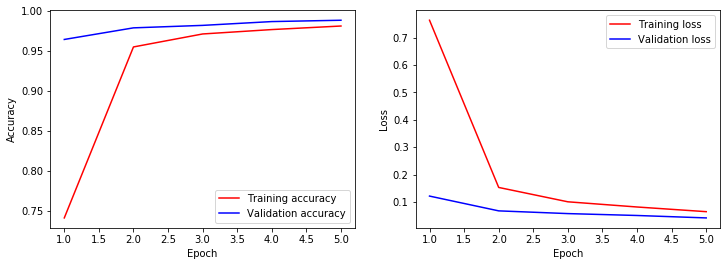

In [10]:
plot_model_results(history)

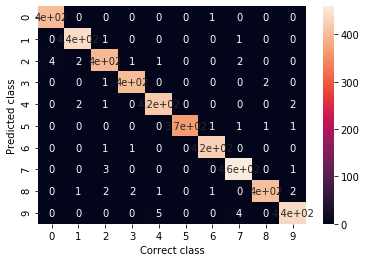

In [11]:
y_pred_dev = np.argmax(CNN.predict(X_dev1), axis=-1)
plot_conf_matrix(y_dev1, y_pred_dev)

Looks good, but can we do better? \**Data augmentation has entered the chat*\*

# Data augmentation

First, import OpenCV and PIL to process images.

In [12]:
import cv2 as cv
from PIL import Image

Functions to convert image representations between numpy arrays and PIL Images

In [13]:
def np_to_pil(image):
    return Image.fromarray(np.uint8(np.squeeze(image) * 255))

def pil_to_np(image):
    return np.array(image)/255

Image augmentation functions

In [14]:
def blur(image):
    # Add Gaussian blur to image
    blurry_img = cv.GaussianBlur(image, (3, 3), 0)
    return blurry_img.reshape(28,28,1)

def rotate(image):
    # Select random angle to rotate image
    angle = 30*np.random.randn()
    # Convert image from numpy to PIL
    img = np_to_pil(image)
    # Apply rotation
    img = img.rotate(angle)
    # Convert image back to numpy
    img_np = pil_to_np(img)
    return img_np.reshape(28,28,1)

def add_noise(image):
    # Add pixelated noise to image
    noisy_img = np.squeeze(image) + 0.1* np.random.randn(28, 28)
    # Clip pixel values between 0 and 1
    noisy_img = np.clip(noisy_img, 0, 1)
    return noisy_img.reshape(28, 28, 1)

def shift(image):
    # Squeeze image to be 2D
    img = np.squeeze(image)
    # Randomly select which kind of shift
    shift_type = np.random.randint(4)
    shift_size = 2
    # Apply shift according to shift type
    if shift_type == 0: # shift upward
        top = img[:shift_size,:]
        bottom = img[shift_size:,:]
        new_img = np.concatenate((bottom,top), axis=0)
    elif shift_type == 1: # shift downward
        top = img[:-shift_size,:]
        bottom = img[-shift_size:,:]
        new_img = np.concatenate((bottom,top), axis=0)
    elif shift_type == 2: # shift leftward
        left = img[:,:shift_size]
        right = img[:,shift_size:]
        new_img = np.concatenate((right,left), axis=1)
    else: # shift rightward
        left = img[:,:-shift_size]
        right = img[:,-shift_size:]
        new_img = np.concatenate((right,left), axis=1)
    return new_img.reshape(28, 28, 1)

Here are some examples of the transformations that can be applied to the images:

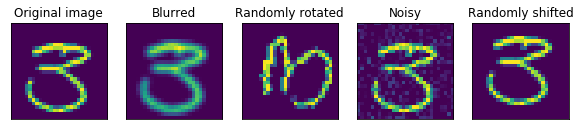

In [15]:
# Select one image
img = X_train[7,:,:,:]

# Create figure, set up subplots
fig, axes = plt.subplots(nrows = 1, ncols = 5, figsize = (10, 10))
plt.setp(axes, xticks=[], yticks=[])

# Show original image
axes[0].imshow(np.squeeze(img))
axes[0].set_title('Original image')

# Show blurred image
axes[1].imshow(np.squeeze(blur(img)))
axes[1].set_title('Blurred')

# Show rotated image
axes[2].imshow(np.squeeze(rotate(img)))
axes[2].set_title('Randomly rotated')

# Show noisy image
axes[3].imshow(np.squeeze(add_noise(img)))
axes[3].set_title('Noisy')

# Show noisy image
axes[4].imshow(np.squeeze(shift(img)))
axes[4].set_title('Randomly shifted')

plt.show()

Now generate 30000 altered samples.

In [16]:
augmented = []
y_augmented = []
num_augmentations = 30000

for i in range(num_augmentations):
    # Select image randomly
    image_ind = np.random.randint(X_train.shape[0])
    image = X_train[i,:,:,:]
    
    y_augmented.append(y_train[i,0])
    
    # Select augmentation randomly
    func = np.random.randint(4)
    if func == 0:
        augmented.append(blur(image))
    elif func == 1:
        augmented.append(rotate(image))
    elif func == 2:
        augmented.append(add_noise(image))
    else:
        augmented.append(shift(image))

X_train_augmented = np.stack(augmented, axis=0)
y_train_augmented = np.array(y_augmented).reshape((-1,1))

Let's take a look at some of these augmented images.

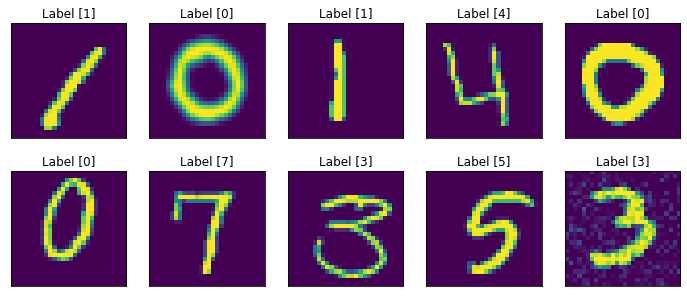

In [17]:
display_several_images(X_train_augmented, np.arange(10), y_train_augmented)

Looks good, now concatenate augmented data with training data and fit model.

In [19]:
# Concatenate training data with augmented data
X_train_new = np.concatenate((X_train1, X_train_augmented), axis=0)
y_train_new = np.concatenate((y_train1, y_train_augmented), axis=0)

# Reset weights for apples-to-apples comparison with non-augmentation set
CNN.set_weights(weights)

# Fit model
history = CNN.fit(X_train_new, y_train_new, batch_size = 500,
                  epochs = 5, verbose = 1,
                  validation_data = (X_dev1, y_dev1))

Epoch 1/5
136/136 [==============================] - 217s 2s/step - loss: 0.6896 - accuracy: 0.7677 - val_loss: 0.0694 - val_accuracy: 0.9776
Epoch 2/5
136/136 [==============================] - 211s 2s/step - loss: 0.1543 - accuracy: 0.9545 - val_loss: 0.0461 - val_accuracy: 0.9840
Epoch 3/5
136/136 [==============================] - 211s 2s/step - loss: 0.1099 - accuracy: 0.9678 - val_loss: 0.0375 - val_accuracy: 0.9886
Epoch 4/5
136/136 [==============================] - 219s 2s/step - loss: 0.0862 - accuracy: 0.9741 - val_loss: 0.0276 - val_accuracy: 0.9914
Epoch 5/5
136/136 [==============================] - 216s 2s/step - loss: 0.0738 - accuracy: 0.9780 - val_loss: 0.0328 - val_accuracy: 0.9907


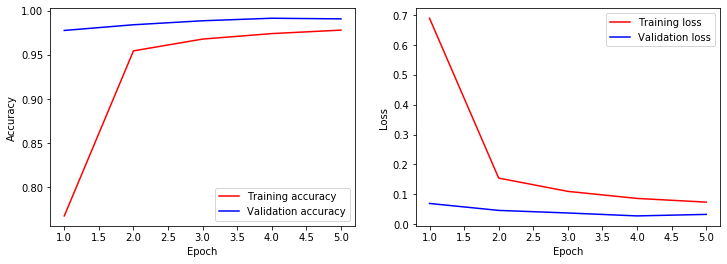

In [20]:
# Plot model accuracy and loss
plot_model_results(history)

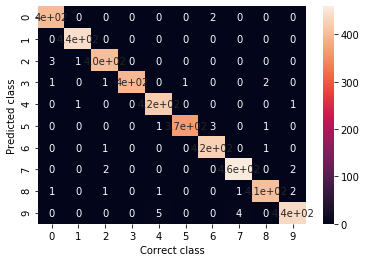

In [21]:
# Plot confusion matrix
y_pred_dev = np.argmax(CNN.predict(X_dev1), axis=-1)
plot_conf_matrix(y_dev1, y_pred_dev)

Looks like data augmentation helped! Let's train it for some more epochs and then make predictions on the test set.

In [22]:
history = CNN.fit(X_train_new, y_train_new, batch_size = 500,
                  epochs = 15, verbose = 1,
                  validation_data = (X_dev1, y_dev1))

Epoch 1/15
136/136 [==============================] - 213s 2s/step - loss: 0.0654 - accuracy: 0.9808 - val_loss: 0.0280 - val_accuracy: 0.9914
Epoch 2/15
136/136 [==============================] - 209s 2s/step - loss: 0.0560 - accuracy: 0.9828 - val_loss: 0.0289 - val_accuracy: 0.9921
Epoch 3/15
136/136 [==============================] - 245s 2s/step - loss: 0.0489 - accuracy: 0.9857 - val_loss: 0.0225 - val_accuracy: 0.9921
Epoch 4/15
136/136 [==============================] - 244s 2s/step - loss: 0.0442 - accuracy: 0.9869 - val_loss: 0.0348 - val_accuracy: 0.9898
Epoch 5/15
136/136 [==============================] - 253s 2s/step - loss: 0.0428 - accuracy: 0.9870 - val_loss: 0.0194 - val_accuracy: 0.9938
Epoch 6/15
136/136 [==============================] - 251s 2s/step - loss: 0.0385 - accuracy: 0.9886 - val_loss: 0.0265 - val_accuracy: 0.9933
Epoch 7/15
136/136 [==============================] - 253s 2s/step - loss: 0.0345 - accuracy: 0.9891 - val_loss: 0.0219 - val_accuracy: 0.9938

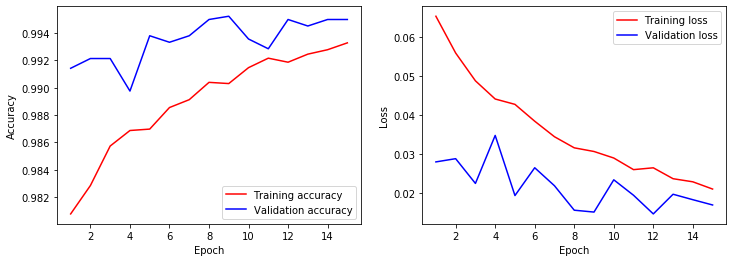

In [23]:
# Plot model accuracy and loss
plot_model_results(history)

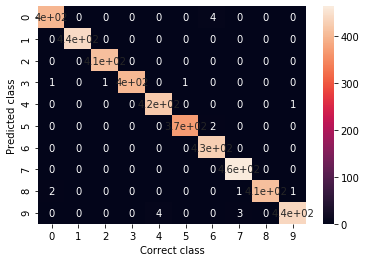

In [24]:
# Plot confusion matrix
y_pred_dev = np.argmax(CNN.predict(X_dev1), axis=-1)
plot_conf_matrix(y_dev1, y_pred_dev)

Apply the model to predict the class of the test data.

In [25]:
y_pred = np.argmax(CNN.predict(X_test), axis=-1)

Display a random sampling of model predictions.

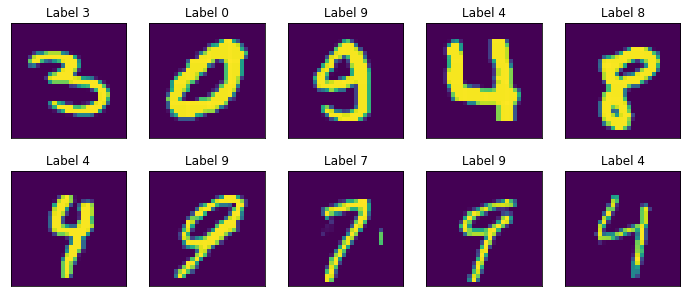

In [26]:
inds = np.random.randint(0, len(y_pred), 10)
display_several_images(X_test, inds, y_pred)

Package up predictions to submit.

In [27]:
# ImageId serves as image index for grading
ImageId = np.arange(1,28001)

# Store predictions in dataframe
predictions = pd.DataFrame({'ImageId': ImageId,
                           'Label': y_pred
                           })

# Save predictions in csv
predictions.to_csv('predictions.csv', index = False)

# Open file to make sure it looks right
pd.read_csv('predictions.csv')

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,0
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


According to Kaggle, these results were 99.26% correct: mission accomplished.